# Overview
This Jupyter notebook describes the case study for the the autonomous systems case study.

In [1]:
# Import libraries
from pacti.iocontract.utils import getVarlist
from PIL import Image
from pacti.terms.polyhedra.loaders import readContract, writeContract

In [2]:
import matplotlib.pyplot as plt
import os
import numpy as np
from matplotlib import patches
import pdb
import sys
sys.path.append('/Users/apurvabadithela/Documents/software/tulip-control/')
from matplotlib.collections import PatchCollection
from tulip.transys import MarkovChain as MC
from tulip.transys import MarkovDecisionProcess as MDP
from itertools import compress, product
from tulip.interfaces import stormpy as stormpy_int
from tulip.transys.compositions import synchronous_parallel

# Importing libraries to setup markov chain
# Setting up the base controllers:
import design_controller4 as K_des
import ped_controller as Kped
import not_ped_controller as Kobj
import empty_controller as Kempty
import importlib

`polytope` failed to import `cvxopt.glpk`.
will use `scipy.optimize.linprog`
`omega.symbolic.symbolic` failed to import `dd.cudd`.
Will use `dd.autoref`.
`tulip` failed to import `cvxopt`.
No quadratic cost for controller computation.


## Part 1: Objects that matter for perception

In [3]:
# Object class definitions
object_classes = {"pedestrian", "obstacle", "bckgnd"}
CM = dict()
for o in object_classes:
    CM["pred_"+str(o)] = {"true_" + str(o) for o in object_classes}
n = len(set(object_classes))

def generate_CM_prob_labels(pred_obj, true_obj):
    prob_label = "P(" + pred_obj + "| " + true_obj +")"
    return prob_label

def generate_labels(true_obj):
    true_obj_prob_labels = [generate_CM_prob_labels(pred_obj, true_obj) for pred_obj in object_classes]
    return true_obj_prob_labels

pedestrian_prob_labels = generate_labels("pedestrian")
obstacle_prob_labels = generate_labels("obstacle")
bckgnd_prob_labels = generate_labels("bckgnd")

## Part 2: System Specifications and System Contracts

In [4]:
TILESIZE = 50
ORIENTATIONS = {'n': 270, 'e': 0, 's': 90,'w':180, 'ne':315, 'nw':225, 'se':45, 'sw':135}
START_CROSSWALK = -1
END_CROSSWALK = 2
CROSSWALK_V = 1
CROSSWALK_LOCATIONS = dict()
ped_loc = []
for i, num in enumerate(range(2*START_CROSSWALK,2*(END_CROSSWALK+1))):
    CROSSWALK_LOCATIONS.update({i: (num/2, CROSSWALK_V)})
    ped_loc.append(num/2)


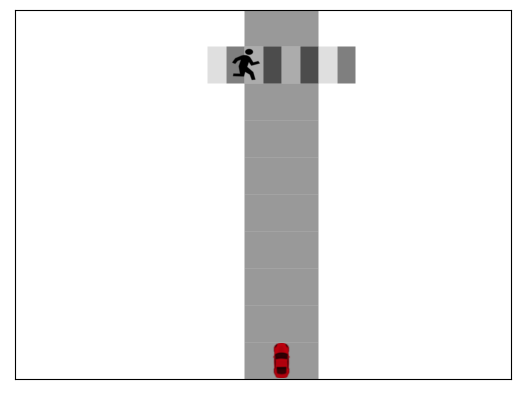

<Figure size 640x480 with 0 Axes>

In [5]:
class GridCar():
    def __init__(self):
        self.xc_init = 0
        self.vc_init = 0
        self.ped = 1
        self.N = 10
        self.Vmax = 2
        self.xped = 10-CROSSWALK_V
        self.main_dir = os.path.dirname(os.path.dirname(os.path.realpath("__file__")))
        self.car_fig = self.main_dir + '/evaluating_perception/imglib/red_car.png'
        self.ped_fig = self.main_dir + '/evaluating_perception/imglib/pedestrian_img.png'
        self.car_data = [9, 0]
        if self.ped == 1:
            self.ped_data = [CROSSWALK_V, min(ped_loc)]
        else:
            self.ped_data = None
    
    def dynamics(self):
        transitions = dict()
        for x in range(0, self.N):
            x_succ = []
            for v in range(0, self.Vmax):
                x_succ.append(x + v)
            transitions[x] = x_succ
        return transitions
    
    def plot_grid(self):
        size = [1, self.N]
        x_min = 0
        x_max = size[0] * TILESIZE
        y_min = 0
        y_max = size[1] * TILESIZE
        # x_min, x_max, y_min, y_max = get_map_corners(map)
        
        fig, ax = plt.subplots()
        ax.axis('equal')
        ax.set_xlim(x_min, x_max)
        ax.set_ylim(y_min, y_max)
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)

        # fill in the road regions
        road_tiles = []
        width_tiles = np.arange(0,size[0]+1)*2*TILESIZE
        lanes_tiles = np.arange(0,size[1]+1)*TILESIZE
        
        for i in np.arange(0,size[0]):
            for k in np.arange(0,size[1]+1):
                tile = patches.Rectangle((width_tiles[i],lanes_tiles[k]),2*TILESIZE,TILESIZE,linewidth=1,facecolor='k', alpha=0.4)
                road_tiles.append(tile)
        ax.add_collection(PatchCollection(road_tiles, match_original=True))

        # now add crosswalk on top
        crosswalk_tiles = []
        for item in CROSSWALK_LOCATIONS.keys():
            if item % 2 == 0:
                color = 'silver'
                alpha = 0.5
            else:
                color = 'k'
                alpha = 0.5
            width = CROSSWALK_LOCATIONS[item][0]*TILESIZE
            lanes = CROSSWALK_LOCATIONS[item][1]*TILESIZE
            tile = patches.Rectangle((width,lanes),TILESIZE/2,TILESIZE,linewidth=1,facecolor=color, alpha=alpha)
            crosswalk_tiles.append(tile)
        ax.add_collection(PatchCollection(crosswalk_tiles, match_original=True))
        # TODO: Add cross-walk tile names next to the cells
        plt.gca().invert_yaxis()
        return ax
    
    
    def plot_car(self, ax):
        y_tile, speed = self.car_data
        theta_d = 270 # Rotate car to face north
        x = (1) * TILESIZE/2
        y = (y_tile) * TILESIZE
        car_fig = Image.open(self.car_fig)
        car_fig = car_fig.rotate(theta_d, expand=False)
        offset = 0.1
        ax.imshow(car_fig, zorder=1, interpolation='bilinear', extent=[x+2, x+TILESIZE-2, y+2, y+TILESIZE-2])
        return ax
    
    def plot_ped(self, ax):
        y_tile, x_tile = self.ped_data
        x = (x_tile) * TILESIZE/2
        y = (y_tile) * TILESIZE
        ped_fig = Image.open(self.ped_fig)
        ped_fig = ped_fig.rotate(180, expand=False)
        offset = 0.1
        ax.imshow(ped_fig, zorder=1, interpolation='bilinear', extent=[x+4, x+TILESIZE-2, y+2, y+TILESIZE-2])
        return ax
    
    # Function to calculate all system states:
    def construct_transitions(self):
        T = dict()
        for xcar in range(1,self.N+1):
            for vcar in range(0, self.Vmax+1):
                st = (xcar, vcar)
                end_st = []
                if xcar == self.N:
                    end_st.append((xcar, vcar))
                elif vcar == 0:
                    xcar_p = min(self.N, xcar+1)
                    end_st.append((xcar, vcar))
                    end_st.append((xcar_p, vcar+1))
                    end_st.append((xcar, vcar+1))
                else:
                    xcar_p = min(self.N, xcar+vcar)
                    end_st.append((xcar_p, vcar))
                    end_st.append((xcar_p, vcar-1))
                    if vcar < Vhigh:
                        end_st.append((xcar_p, vcar+1))
                T[st] = end_st
        return T
    
    # System states for pedestrian
    def system_states_example_ped(self):
        nS = self.N*(self.Vmax+1)
        state = lambda x,v: (self.Vmax+1)*(x-1) + v
        state_to_S = dict()
        S = set()
        for xcar in range(1,self.N+1):
            for vcar in range(0, self.Vmax+1):
                st = "S"+str(state(xcar, vcar))
                state_to_S[xcar,vcar] = st
                S|={st}
        T = self.construct_transitions()
        return S, state_to_S, T


# Generate grid and figure:
grid = GridCar()
ax = grid.plot_grid()
ax = grid.plot_car(ax)
ax = grid.plot_ped(ax)

plt.show()
plt.savefig(grid.main_dir + "/evaluating_perception/imglib/car_ped_ex.png")

## Part 2A: Constructing the transition system and parametric MC

In [6]:
# Construct Confusion Matrix (3 by 3 with pedestrian, obstacle, background)
def construct_CM(tp_ped, tp_obj, tp_emp):
    C = dict()
    C["ped", "ped"] = tp_ped
    C["ped", "obj"] = 0.1*(1-tp_ped)
    C["ped", "empty"] = 0.9*(1-tp_ped)
    
    C["obj", "ped"] = 0.1*(1-tp_obj)
    C["obj", "obj"] = tp_obj
    C["obj", "empty"] = 0.9*(1-tp_obj)
    
    C["empty", "ped"] = 0.5*(1-tp_emp)
    C["empty", "obj"] = 0.5*(1-tp_emp)
    C["empty", "empty"] = tp_emp
    return C

In [7]:
# Function that converts to a Markov chain from states and actions:
def _construct_mdpmc(states, transitions, init, actions=None):
    if actions is not None:
        ts = MDP()
        ts.actions.add_from(actions)
    else:
        ts = MC()
    ts.states.add_from(states)
    ts.states.initial.add(init)

    for transition in transitions:
        attr = {"probability": transition[2]}
        if len(transition) > 3:
            attr["action"] = transition[3]
        ts.transitions.add(
            transition[0],
            transition[1],
            attr,
        )

    for s in states:
        ts.atomic_propositions.add(s)
        ts.states[s]["ap"] = {s}
    return ts

# Function to return a list of all combinations of inputs:
# Input: A dictionary names D
# Each key of D corresponds to a set of values that key can take
# Output: All combinations of input keys
def dict_combinations(D):
    keys = D.keys()
    values = list(D.values())
    prod_input = list(product(*values))
    return prod_input

## Parametric Markov chain synthesis class:
model_MC = "model_MC.nm"
class MarkovChain:
    def __init__(self, S, O, state_to_S):
        self.states = S    # Product states for car.
        self.state_dict = state_to_S
        self.reverse_state_dict = {v: k for k, v in state_to_S.items()}
        self.obs = O
        self.true_env = None # This state is defined in terms of the observation
        self.true_env_type = None # Type of the env object; is in one of obs
        self.C = dict() # Confusion matrix dictionary giving: C[obs, true] =  P(obs |- phi | true |- phi)
        self.M = dict() # Two-by-two dictionary. a(i,j) = Prob of transitioning from state i to state j
        self.K = None # Depending on the observation, the controller changes. This is a dictionary of the controller after the Mealy machine is syntehsized from specifications
        self.K_strategy = None # Dictionary containing the scripts to the controller after it has been written to file
        self.formula = []
        self.K_int_state_map = dict() # Nested dictionary mapping internal states to concrete states of the controller instantiation
        self.K_int_state_map_inv = dict() # Nested dictionary mapping concrete states of controller instance into internal states
        self.MC = None # A Tulip Markov chain object that is consistent with TuLiP transition system markov chain
        self.true_env_MC = None # A Markov chain representing the true evolution of the environment
        self.backup = dict() # This is a backup controller.

    # Convert this Markov chain object into a tulip transition system:
    def to_MC(self, init):
        states = set(self.states) # Set of product states of the car
        transitions = set()
        for k in self.M.keys():
            p_approx = min(1, abs(self.M[k])) # Probabilities cannot be greater than 1
            if abs(1-self.M[k]) > 1e-2:
                print(abs(1-self.M[k]))
            t = (k[0], k[1], p_approx)
            transitions |= {t}
        assert init in self.states
        self.MC = _construct_mdpmc(states, transitions, init)
        markov_chain = _construct_mdpmc(states, transitions, init)
        for state in self.MC.states:
            self.MC.states[state]["ap"] = {state}
        self.check_MC() # Checking if Markov chain is valid
        return markov_chain

# Writing/Printing Markov chains to file:
    def print_MC(self):
        model_path = os.path.join(os.path.dirname(os.path.abspath(__file__)), "models")
        path_MC = os.path.join(model_path, model_MC)
        env_MC = os.path.join(model_path, "env_MC.nm")
        path_MC_model = stormpy_int.build_stormpy_model(path_MC)
        env_MC_model = stormpy_int.build_stormpy_model(env_MC)
        stormpy_int.print_stormpy_model(path_MC_model)
        stormpy_int.print_stormpy_model(env_MC_model)

   # Function to check if all outgoing transition probabilities for any state in the Markov chain sum to 1.
    def check_MC(self):
        T = self.MC.transitions(data=True)
        # Printing all states and outgoing transitions
        for st in self.MC.states:
            print("State: ", st)
            end_states = [t for t in T if t[0]==st]
            prob = [(t[2])['probability'] for t in end_states]
            print("probability of end states: ", str(prob))
            if not abs(sum(prob)-1)<1e-4:
                pdb.set_trace()
            assert abs(sum(prob)-1)<1e-4 # Checking that probabilities add up to 1 for every state

   # Sets the state of the true environment
   # True env type is the string form of the object and st is the corresponding state
    def set_true_env_state(self, st, true_env_type):
        self.true_env = st
        new_st = "p"+st
        states = {new_st}
        transitions ={(new_st, new_st, 1)}
        init = new_st
        self.true_env_type = true_env_type
        self.true_env_MC = _construct_mdpmc(states, transitions, init)

    # Parametric confusion matrix:
    def set_confusion_matrix(self, C):
        self.C = C
        
    # Depending on the observation, the controller K changes. K should be a dictionary that maps observation to a controller. ToDo: Assess difference between K and K_strategy
    def set_controller(self, K, K_strategy, K_backup):
        self.K_strategy = K_strategy
        self.K = K
        self.backup = K_backup
    
    # Determining transition to next state based on the env observed in the current state
    # This part is critical and depends on the controller corresponding to the predicted env state
    def compute_next_state(self,obs,env_st, init_st): # The next state computed using the observation from the current state
        Ki = self.K[obs] # The controller object
        Ki_strategy =self.K_strategy[obs]
        K_instant, sinit_adj, flg = self.adjust_state(Ki, Ki_strategy,obs,init_st) # If flg = 1, use sinit_adj as given by backup controller
        if flg == 0:
            next_st = K_instant.move(*env_st) # Might have to modify this when there are multiple observations
        else:
            next_st = {'xcar': sinit_adj[0], 'vcar': sinit_adj[1]}
        return next_st

    # Function to construct a map of internal states of various controllers:
    # TODO: Debug
    def construct_internal_state_maps(self):
        for obs in self.obs:
            Ki = self.K[obs]
            Ki_strategy = self.K_strategy[obs]
            inputs = Ki.inputs # Input dictionary mapping input variables to range of values
            outputs = Ki.outputs # Output dictionary mapping output variable to range of values
            input_comb = dict_combinations(inputs)
            output_comb = dict_combinations(outputs)
            K_inst = Ki_strategy.TulipStrategy() # Instantiation
            N_int_states = K_inst.state # Total no. of internal states
#             print(inputs)
#             print(input_comb)
#             print("Inputs: ")
#             print(input_comb)
#             print("Outputs: ")
#             print(output_comb)
            # Check --> good upto this point
            self.K_int_state_map[Ki] = dict()
            self.K_int_state_map_inv[Ki] = dict()
            
            # Instantiate a different input state map for different initial conditions that you can observe:
            for inp in input_comb:
                self.K_int_state_map[Ki][inp] = dict()
                self.K_int_state_map_inv[Ki][inp] = dict()
                # Populating the dictionary:
                for ii in range(N_int_states):
                    self.K_int_state_map[Ki][inp][ii] = None # None object

            # Modifying the list:
            for int_st in range(N_int_states+1):
                # print("Internal state: ", str(int_st))
                for inp in input_comb:
                    K_inst.state = int_st # Modifying internal state to stay where it is
                    # print("Input: ", str(inp))
                    try: # Adding the environment state
                        out = K_inst.move(*inp)
                        state = K_inst.state
                        # print("State moved: ", str(state))
                        if (state == 2):
                            flg = 1
                        if self.K_int_state_map[Ki][inp][state] is None:
                            # print("Output value: ", list(out.values()))
                            self.K_int_state_map[Ki][inp][state] = list(out.values()) # Updating state
                            assert self.K_int_state_map[Ki][inp][state] is not None
                    except Exception:
                        pass

            # Reversing the internal state map:
            # Adding only those states that are not of type None
            for inp in input_comb:
                for k,v in self.K_int_state_map[Ki][inp].items():
                    if v is not None:
                        self.K_int_state_map_inv[Ki][inp][tuple(v)] = k


    # Adjust state of the system based on the controller that's being used so it doesn't throw an error:
    # Ki is the controller and Ki_strategy is the script that corresponds to the strategy
    # of Ki. One of the variables returned is also K_instant (the instantiation of the controller)
    def adjust_state(self,Ki, Ki_strategy, obs,  sinit_st):
        flg =0 # Default
        inp_st = tuple(self.get_env_state(obs))
        if sinit_st not in self.K_int_state_map_inv[Ki][inp_st].keys():
            poss_st = self.backup[sinit_st]
            test_list = [p for p in poss_st if (p[0]==sinit_st[0] and p[1]==1)]  # If sinit_st is at zero velocity, car should not remain stuck at 0 velocity.
            flg = 1
            K_instant = None
            if test_list:
                init_st_adj = test_list[0]
            else:
                init_st_adj = poss_st[0]
        else:
            init_st_adj=(self.K_int_state_map_inv[Ki][inp_st])[sinit_st] # Finding the mapping from internal states
            print("Adjusted state: ", init_st_adj)
            K_instant = Ki_strategy.TulipStrategy()
            K_instant.state = init_st_adj
        return K_instant, init_st_adj, flg

    # Function to return the state of the environment given the observation:
    def get_env_state(self, obs):
        env_st =[1] # For static environment, env state is the same. Should modify this function for reactive environments
        if obs == self.true_env_type:
            env_st = [int(self.true_env)]
        return env_st

    # Constructing the Markov chain
    def construct_markov_chain(self): # Construct probabilities and transitions in the markov chain given the controller and confusion matrix
        for Si in list(self.states):
            print("Finding initial states in the Markov chain: ")
            print(Si)
            init_st = self.reverse_state_dict[Si]
            out_states = []
            if init_st == (8,3) or init_st == (3,0):
                pdb.set_trace()
            # The output state can be different depending on the observation as defined by the confusion matrix
            for obs in self.obs:
                # print("The observation is as follows: ")
                # print(obs)
                env_st = self.get_env_state(obs)
                next_st = self.compute_next_state(obs, env_st, init_st)
                # print("The next state for this observation is as follows: ")
                # print(next_st)
                Sj = self.state_dict[tuple(next_st.values())]
                try:
                    prob_t = self.C[(obs, self.true_env_type)] # Parametric probability of transitions
                except:
                    pdb.set_trace()
                if (Si, Sj) in self.M.keys():
                    self.M[Si, Sj] = self.M[Si, Sj] + prob_t
                else:
                    self.M[Si, Sj] = prob_t
                if Sj not in out_states:
                    out_states.append(Sj)
            sum_probs = sum([self.M[Si, Sj] for Sj in out_states])
#             if init_st[0] <= 16:
#                 if abs(1-sum_probs) > 1e-4:
#                     pdb.set_trace() # Sanity check
        return self.M
    
    # Adding formulae to list of temporal logic formulas:
    def add_TL(self, phi):
        self.formula.append(phi)

    # Probabilistic satisfaction of a temporal logic with respect to a model:
    def prob_TL(self, phi):
        model_path = os.path.join(os.path.dirname(os.path.abspath(__file__)), "models")
        prism_file_path = os.path.join(model_path, "pedestrian.nm")
        path_MC = os.path.join(model_path, model_MC)
        env_MC = os.path.join(model_path, "env_MC.nm")
        # Print self markov chain:
        # print(self.MC)
        # Writing prism files:
        stormpy_int.to_prism_file(self.MC, path_MC)
        stormpy_int.to_prism_file(self.true_env_MC, env_MC)
        composed = synchronous_parallel([self.MC, self.true_env_MC])
        # print(composed.transitions)
        result = stormpy_int.model_checking(composed, phi, prism_file_path)
        # Returns a tulip transys:
        # MC_ts = stormpy_int.to_tulip_transys(path_MC)
        result = stormpy_int.model_checking(self.MC, phi, prism_file_path) # Since there is no moving obstacle, try checking only the pedestrian obstacle
        #for state in self.MC.states:
        #    print("  State {}, with labels {}, Pr = {}".format(state, self.MC.states[state]["ap"], result[str(state)]))
        return result

    # Function to append labels to a .nm file:
    def add_labels(self, MAX_V):
        model_path = os.path.join(os.path.dirname(os.path.abspath(__file__)), "models")
        path_MC = os.path.join(model_path, prop_model_MC)
        for vi in range(0, MAX_V):
            var = "label \"v_"+str(vi)+"\"="
            flg_var = 0 # Set after the first state is appended
            for k, val in self.state_dict.items():
                if k[1] == vi:
                    if flg_var == 0:
                        flg_var = 1
                        var = var + "(s = "
                    var = var + ""
            with open(path_MC, 'a') as out:
                out.write(var + '\n')

In [8]:
def call_MC(K, K_backup, C, true_env, true_env_type, state_info, M):
    importlib.reload(Kped)
    importlib.reload(Kobj)
    importlib.reload(Kempty)
    
    K_strat = dict()
    K_strat["ped"] = Kped
    K_strat["obj"] = Kobj
    K_strat["empty"] = Kempty
    
    obs_keys = dict()
    obs_keys["ped"] = ["xcar", "vcar"]
    obs_keys["obj"] = ["xobj"]
    obs_keys["empty"] = ["xempty"]
    
    M.set_confusion_matrix(C)
    M.set_true_env_state(true_env, true_env_type)
    M.set_controller(K, K_strat, K_backup)
    
    M.construct_internal_state_maps()
    
    # Construct Markov chain:
    M.construct_markov_chain()
    start_state = state_info["start"]
    bad_states = state_info["bad"]
    good_state = state_info["good"]
    MC = M.to_MC(start_state) # For setting initial conditions and assigning bad/good labels
    print(M.M)
    return M

def initialize(vmax, MAX_V):
    Ncar = int(MAX_V*(MAX_V+1)/2 + 10)
    Vlow =  0
    Vhigh = vmax
    x_vmax_stop = MAX_V*(MAX_V+1)/2 + 1
    xcross_start = 2
    Nped = Ncar - xcross_start + 1
    if x_vmax_stop >= xcross_start:
        min_xped = int(x_vmax_stop + 1 - (xcross_start - 1))
    else:
        min_xped = 3
    assert(min_xped > 0)
    assert(min_xped<= Nped)
    if min_xped < Nped:
        xped = np.random.randint(min_xped, Nped)
    else:
        xped = int(min_xped)
    xped = int(min_xped)
    xcar_stop = xped + xcross_start - 2
    assert(xcar_stop > 0)
    state_f = lambda x,v: (Vhigh-Vlow+1)*(x-1)+v
    bad_states = set()
    good_state = set()
    
    def get_formula_states(xcar_stop):
        bst = set()
        for vi in range(0,Vhigh+1):
            state = state_f(xcar_stop, vi)
            bst |= {"S"+str(state)}
        gst = {"S" + str(state_f(xcar_stop,0))}
        bad = "" # Expression for bad states
        good = "" # Expression for good states
        for st in list(gst):
            if good == "":
                good = good + "\"" + st+"\""
            else:
                good = good + "|\""+st+"\""
        for st in list(bst):
            if bad == "":
                bad = bad + "\"" + st+"\""
            else:
                bad = bad + "|\""+st+"\""
        return good, bad, gst, bst
    good, bad, gst, bst = get_formula_states(xcar_stop)
    good_state |= gst
    bad_states |= bst
    formula = "P=?[!("+str(bad)+") U "+str(good)+"]"
    
    phi1 = "!("+good+")"
    phi2 = "("+good+") | !("+bad
    for xcar_ii in range(xcar_stop+1, Ncar+1):
        good, bad, gst, bst = get_formula_states(xcar_ii) # We only want the bad states; ignore the good states output here
        bad_states |= bst
        phi2 = phi2 + "|" + bad
    phi2 = phi2 + ")"
    formula = "P=?[G("+str(phi1)+") && G("+str(phi2)+")]"
    return Ncar, Vlow, Vhigh, xcross_start, xped, bad_states, good_state, formula

# Construct backup controller:
def construct_backup_controller(Ncar, Vlow, Vhigh):
    K_backup = dict()
    for xcar in range(1,Ncar+1):
        for vcar in range(Vlow, Vhigh+1):
            st = (xcar, vcar)
            end_st = []
            if xcar == Ncar:
                end_st.append((xcar, vcar))
            elif vcar == 0:
                xcar_p = min(Ncar, xcar+1)
                end_st.append((xcar, vcar))
                end_st.append((xcar_p, vcar+1))
                end_st.append((xcar, vcar+1))
            else:
                xcar_p = min(Ncar, xcar+vcar)
                end_st.append((xcar_p, vcar))
                end_st.append((xcar_p, vcar-1))
                if vcar < Vhigh:
                    end_st.append((xcar_p, vcar+1))
            K_backup[st] = end_st
    return K_backup

# Creating the states of the markov chain for the system:
# Returns product states S and (pos,vel) to state dictionary
def system_states_example_ped(Ncar, Vlow, Vhigh):
    nS = Ncar*(Vhigh-Vlow+1)
    state = lambda x,v: (Vhigh-Vlow+1)*(x-1) + v
    state_to_S = dict()
    S = set()
    for xcar in range(1,Ncar+1):
        for vcar in range(Vlow, Vhigh+1):
            st = "S"+str(state(xcar, vcar))
            state_to_S[xcar,vcar] = st
            S|={st}
    K_backup = construct_backup_controller(Ncar, Vlow, Vhigh)
    return S, state_to_S, K_backup

def get_states_and_controllers(C, M, start_state, good_state, bad_states, K, K_backup):
    true_env = str(1) #Sidewalk 3
    true_env_type = "empty"
    state_info = dict()
    state_info["start"] = start_state
    state_info["bad"] = bad_states
    state_info["good"] = good_state
    for st in list(good_state):
        formula2 = 'P=?[G!(\"'+st+'\")]'
    MC = call_MC(K, K_backup, C, true_env, true_env_type, state_info, M)
    # result = M.prob_TL(formula)
    result2 = MC.prob_TL(formula2)
    print('Probability of eventually reaching good state for initial speed, {}, and max speed, {} is p = {}:'.format(vcar, vmax, result2[start_state]))
    return result2[start_state]

In [ ]:
MAX_V = 5
vmax = MAX_V
Ncar, Vlow, Vhigh, xcross_start, xped, bad_states, good_state, formula = initialize(vmax, MAX_V)

# Construct state (x,v) back from state:
def state_f(x,v):
    S_value = (Vhigh-Vlow+1)*(x-1) + v
    return S_value

# Generate probability points from Confusion Matrix:
def gen_points():
    points_ped = [] # Satisfaction probabilities for true env as ped
    points_obj = [] # Satisfaction probabilities for true env as ped
    points_emp = [] # Satisfaction probabilities for true env as ped
       
    vcar = 5 # Initial speed at starting point
    start_state = "S"+str(state_f(1,vcar))
    S, state_to_S, K_backup = system_states_example_ped(Ncar, Vlow, Vhigh)
    O = {"ped", "obj", "empty"}
    K = K_des.construct_controllers(Ncar, Vlow, Vhigh, xped, vcar, xcross_start)
    M = MarkovChain(S, O, state_to_S)
    
    tp_range = np.linspace(0.6, 0.99, num=5)
    for tp_ped in tp_range:
        tp_obj = 0.8
        tp_emp = 0.8
        C = construct_CM(tp_ped, tp_obj, tp_emp)
        prob = get_states_and_controllers(C, M, start_state, good_state, bad_states, K, K_backup)
        points_ped.append(prob)
    print("Found probabilities for pedestrian env!")
    
    for tp_obj in tp_range:
        tp_ped = 0.8
        tp_emp = 0.8
        C = construct_CM(tp_ped, tp_obj, tp_emp)
        prob = get_states_and_controllers(C, M, start_state, good_state, bad_states, K, K_backup)
        points_obj.append(prob)
    print("Found probabilities for obj env!")
    
    for tp_emp in tp_range:
        tp_obj = 0.8
        tp_ped = 0.8
        C = construct_CM(tp_ped, tp_obj, tp_emp)
        prob = get_states_and_controllers(C, M, start_state, good_state, bad_states, K, K_backup)
        points_emp.append(prob)
    return points_ped, points_obj, points_emp

points_ped, points_obj, points_emp = gen_points()

removed 0 nodes from 14 total
removed 0 nodes from 16 total
removed 0 nodes from 7 total
Finding initial states in the Markov chain: 
S59
Finding initial states in the Markov chain: 
S146
Finding initial states in the Markov chain: 
S107
Finding initial states in the Markov chain: 
S75
Finding initial states in the Markov chain: 
S17
Finding initial states in the Markov chain: 
S78
Finding initial states in the Markov chain: 
S127
Adjusted state:  11
Finding initial states in the Markov chain: 
S105
Finding initial states in the Markov chain: 
S120
Finding initial states in the Markov chain: 
S49
Finding initial states in the Markov chain: 
S97
Adjusted state:  6
Finding initial states in the Markov chain: 
S47
Finding initial states in the Markov chain: 
S50
Finding initial states in the Markov chain: 
S142
Finding initial states in the Markov chain: 
S56
Finding initial states in the Markov chain: 
S135
Finding initial states in the Markov chain: 
S101
Finding initial states in the M

## Part 3: Controller Contracts

## Part 4: Computing desired probabilities for Confusion Matrix